In [ ]:
# default_exp l10_anneal

In [ ]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from tensorflow.keras.datasets import mnist
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_data():
    (x_train,y_train),(x_valid,y_valid)= mnist.load_data()
    x_train,y_train, x_valid, y_valid = map(torch.from_numpy,(x_train,y_train,x_valid,y_valid))
    l=[x_train, y_train,x_valid, y_valid]
    for i in range(len(l)):
      sh=l[i].shape
      l[i]=l[i].reshape(sh[0],-1)
    return l[0].float()/255,l[1].squeeze(-1).long(), l[2].float()/255,l[3].squeeze(-1).long()

 
class Dataset():
  def __init__(self, x,y): self.x, self.y= x,y 
  def __len__(self): return len(self.x)
  def __getitem__(self, n): return self.x[n], self.y[n]


class DataBunch():
  def __init__(self, train_dl, valid_dl, c=None): self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
  @property
  def train_ds(self): return self.train_dl.dataset
  @property
  def valid_ds(self): return self.valid_dl.dataset

class Learner():
  def __init__(self, model, opt, loss_func, data): 
    self.model, self.opt, self.loss_func,self.data = model, opt, loss_func, data


def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [ ]:
#export
from torch import optim
def get_model(data, lr=0.5,nh=50):
    m=data.train_ds.x.shape[1]
    model=nn.Sequential(nn.Linear(m,nh),nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)
    
def get_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [ ]:
x_train, y_train, x_valid, y_valid=get_data()
bs=32

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
cat=y_train.max().item()+1
train_ds=Dataset(x_train, y_train)
valid_ds=Dataset(x_valid, y_valid)
data = DataBunch(*get_dls(train_ds, valid_ds, bs), cat)

loss_func = F.cross_entropy

In [ ]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')


In [ ]:

#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [ ]:

#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [ ]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [ ]:
learn=get_learner(get_model,loss_func, data)
run= Runner(AvgStatsCallback([accuracy]))

In [ ]:
run.fit(2,learn)

train: [0.27255242513020833, tensor(0.9161)]
valid: [0.1672127197265625, tensor(0.9515)]
train: [0.13846796875, tensor(0.9580)]
valid: [0.14924234619140625, tensor(0.9565)]


In [ ]:
#export
from functools import partial

In [ ]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses=[],[]
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self,pname, sched_func): self.pname, self.sched_func = pname, sched_func
    
    def set_param(self): 
        for pg in self.opt.param_groups:
            pg[self.pname]=self.sched_func(self.n_epochs/self.epochs)
    def begin_batch(self):
        if self.in_train: self.set_param()

In [ ]:
def sched_lin(start,end):
    def _inner(start, end, pos): return start+ pos*(end-start)
    return partial(_inner, start,end)

In [ ]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner
@annealer
def sched_lin(start,end,pos): return start+ pos*(end-start)

In [ ]:
f=sched_lin(1,2)
f(0.5)

1.5

In [ ]:
#export
@annealer
def sched_cos(start,end,pos):return start+(1+math.cos(math.pi*(1-pos)))*(end-start)/2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_expo(start,end, pos): return (end/start)**pos

def cos_1cycle_anneal(start, high,end):
    return [sched_cos(start, high),sched_cos(high, end)]

torch.Tensor.ndim=property(lambda x: len(x.shape))

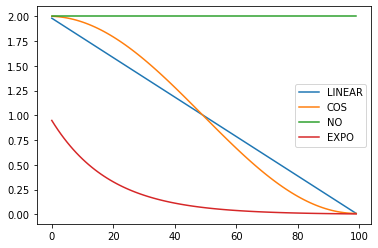

In [ ]:
annealings='LINEAR COS NO EXPO'.split()
a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_lin, sched_cos, sched_no, sched_expo]
for fn, t in zip(fns, annealings):
    f=fn(2,1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend()

In [ ]:
#export
def combine_scheds(pcts, scheds):
  assert sum(pcts)==1.
  pcts=tensor([0]+listify(pcts))
  assert torch.all(pcts>=0)
  pcts= torch.cumsum(pcts,0)
  def _inner(pos):
    idx = (pos>=pcts).nonzero().max()
    actual_pos=(pos-pcts[idx])/(pcts[idx+1]-pcts[idx])
    return scheds[idx](actual_pos)
  return _inner



In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

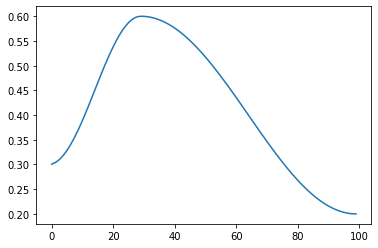

In [ ]:
plt.plot(a, [sched(o) for o in p])

In [ ]:
cbfs=[Recorder, partial(AvgStatsCallback,accuracy), partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn=get_learner(get_model,loss_func, data)
run=Runner(cb_funcs=cbfs)

In [ ]:
run.fit(3,learn)

train: [0.2911476236979167, tensor(0.9113)]
valid: [0.2359377685546875, tensor(0.9306)]
train: [0.144220361328125, tensor(0.9559)]
valid: [0.13798929443359376, tensor(0.9575)]
train: [0.07947606608072917, tensor(0.9748)]
valid: [0.09116539306640625, tensor(0.9734)]


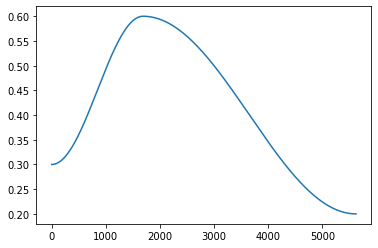

In [ ]:
run.recorder.plot_lr()

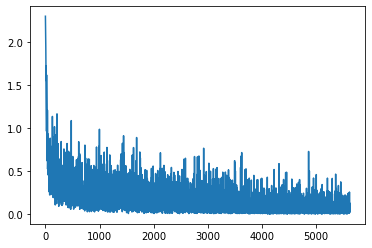

In [ ]:
run.recorder.plot_loss()